In [ ]:
# Import standard libraries
import sys
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Scikit-learn components
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Model classes
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (accuracy_score, precision_score, 
                           recall_score, f1_score, roc_auc_score)

# Path configuration
sys.path.append('../src')

sys.path.append('../src') 



## Load Dataset
I used paraquet to load the dataset as-is

In [2]:
import os

# use paraquet to load the data as-is
# Define the target directory path
parquet_dir = "../data/processed/"

# Create the directory if it doesn't exist
os.makedirs(parquet_dir, exist_ok=True)  # `exist_ok=True` prevents errors if dir already exists
df = pd.read_parquet(os.path.join(parquet_dir, "processed_dataset.parquet"))


Data Preprocessing

Handling Missing Data

In [3]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing %', ascending=False)
print(missing_df)


           Missing Count  Missing %
LossRatio         381080  38.128132


In [4]:
# fill with the median of loss ratio
df['LossRatio'] = df['LossRatio'].fillna(df['LossRatio'].median())

In [5]:
print("Remaining missing LossRatio:", df['LossRatio'].isnull().sum())


Remaining missing LossRatio: 0


Feature Engineering | Feature Selection

In [7]:
from datetime import datetime

# Vehicle age features
current_year = datetime.now().year
df['VehicleAge'] = current_year - df['RegistrationYear']
df['ModelAge'] = (df['TransactionMonth'].dt.year - df['VehicleIntroDate'].dt.year)

# Policy features
df['PremiumToSumInsuredRatio'] = df['CalculatedPremiumPerTerm'] / df['SumInsured']

# Temporal features
df['TransactionMonth'] = df['TransactionMonth'].dt.month
df['VehicleIntroQuarter'] = df['VehicleIntroDate'].dt.quarter

In [ ]:


# Convert datetime columns to numerical features
def process_datetime(df):
    for col in df.select_dtypes(include=["datetime64[ns]"]).columns:
        df[f"{col}_year"] = df[col].dt.year
        df[f"{col}_month"] = df[col].dt.month
        df[f"{col}_day"] = df[col].dt.day
        df.drop(columns=[col], inplace=True)
    return df



Handle Missing Values, Infinite Values and Large numbers

In [ ]:


def clean_data(df):
    """Handle missing values, infinite values, and large numbers"""
    df = df.copy()
    
    # Replace infinities with NaN
    df = df.replace([np.inf, -np.inf], np.nan)
    
    # Handle numeric columns
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        # Cap extreme values at 99.9th percentile
        upper_limit = df[col].quantile(0.999)
        lower_limit = df[col].quantile(0.001)
        df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])
        df[col] = np.where(df[col] < lower_limit, lower_limit, df[col])
        
        # Fill remaining NaNs with median
        df[col] = df[col].fillna(df[col].median())
    
    return df

# Apply cleaning
data_clean = clean_data(df)

# Convert datetime columns (as shown in previous solution)
data_processed = process_datetime(data_clean)

# Separate features and target
X = data_processed.drop(['TotalClaims', 'TotalPremium'], axis=1)
y_sev = data_processed['TotalClaims']
y_prob = (data_processed['TotalClaims'] > 0).astype(int)

# Identify column types
cat_cols = X.select_dtypes(include=['category', 'object', 'bool']).columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

Encoding Data

In [17]:
# Create preprocessing pipeline with proper handling of numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

Claim Severity

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

def build_model(estimator):
    return Pipeline([
        ('preprocessor', preprocessor),
        ('estimator', estimator)
    ])

# For claim severity (only policies with claims > 0)
claims_data = data_processed[data_processed['TotalClaims'] > 0]
X_sev = claims_data.drop(['TotalClaims', 'TotalPremium'], axis=1)
y_sev = claims_data['TotalClaims']

# Split data
X_sev_train, X_sev_test, y_sev_train, y_sev_test = train_test_split(
    X_sev, y_sev, test_size=0.2, random_state=42)

try:
    # Linear Regression
    lr_pipe = build_model(LinearRegression())
    lr_pipe.fit(X_sev_train, y_sev_train)
    lr_pred = lr_pipe.predict(X_sev_test)
    lr_rmse = np.sqrt(mean_squared_error(y_sev_test, lr_pred))
    lr_r2 = r2_score(y_sev_test, lr_pred)
    
    # Random Forest
    rf_pipe = build_model(RandomForestRegressor(
        n_estimators=100, 
        random_state=42,
        max_depth=10  # Prevent overfitting
    ))
    rf_pipe.fit(X_sev_train, y_sev_train)
    rf_pred = rf_pipe.predict(X_sev_test)
    rf_rmse = np.sqrt(mean_squared_error(y_sev_test, rf_pred))
    rf_r2 = r2_score(y_sev_test, rf_pred)
    
    # XGBoost with careful parameter settings
    xgb_pipe = build_model(xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        random_state=42,
        max_depth=6,  # Shallower trees prevent overfitting
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8
    ))
    xgb_pipe.fit(X_sev_train, y_sev_train)
    xgb_pred = xgb_pipe.predict(X_sev_test)
    xgb_rmse = np.sqrt(mean_squared_error(y_sev_test, xgb_pred))
    xgb_r2 = r2_score(y_sev_test, xgb_pred)
    
except Exception as e:
    print(f"Error during model training: {str(e)}")
    # Implement fallback strategy or logging here

In [19]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'RMSE': [lr_rmse, rf_rmse, xgb_rmse],
    'R-squared': [lr_r2, rf_r2, xgb_r2]
})

print("Model Performance Comparison:")
print(results)

Model Performance Comparison:
               Model         RMSE  R-squared
0  Linear Regression  3330.855708   0.827594
1      Random Forest  1457.334601   0.966997
2            XGBoost  1745.848542   0.952635


Among the three models evaluated for predicting claim severity, Random Forest performed best with the lowest RMSE (1457.33) and highest R² (0.967), indicating strong accuracy and ability to capture complex patterns. XGBoost followed closely with slightly higher error but still strong performance (RMSE: 1745.85, R²: 0.954). Linear Regression, with the highest RMSE (3330.86) and lowest R² (0.828), underperformed and is not suitable for this task. Therefore, Random Forest is recommended as the most effective model for claim severity prediction.

Feature Importance Analysis: Random Forest Model for Claim Severity

In [20]:
# For Random Forest
importances = rf_pipe.named_steps['estimator'].feature_importances_
feature_names = (num_cols.tolist() + 
                rf_pipe.named_steps['preprocessor']
                .named_transformers_['cat']
                .named_steps['onehot']
                .get_feature_names_out(cat_cols).tolist())

pd.DataFrame({'feature': feature_names, 'importance': importances})\
  .sort_values('importance', ascending=False)\
  .head(20)

,feature,importance
10,SumInsured,0.625427
12,LossRatio,0.214277
11,CalculatedPremiumPerTerm,0.081204
14,PremiumToSumInsuredRatio,0.050716
6,cubiccapacity,0.001820
2,PostalCode,0.001670
1,PolicyID,0.001638
0,UnderwrittenCoverID,0.001585
3,mmcode,0.001565
7,kilowatts,0.001040


SHAP Analysis for Identifying Important Features

In [21]:
%pip install shap

   ---------------------------------------- 0.0/545.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/545.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/545.1 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.1 kB ? eta -:--:--
   -------------------------------------- 545.1/545.1 kB 800.1 kB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.8 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.8 MB 1.5 MB/s eta 0:00:02
   ------- -------------------------------- 0.5/2.8 MB 1.5 MB/s eta 0:00:02
   ----------- ---------------------------- 0.8/2.8 MB 1.1 MB/s eta 0:00:02
   -------------- ------------------------- 1.0/2.8 MB 938.5 kB/s eta 0:00:02
   -------------- ------------------------- 1.0/2.8 


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Feature Importance Using SHAP for XGBoost

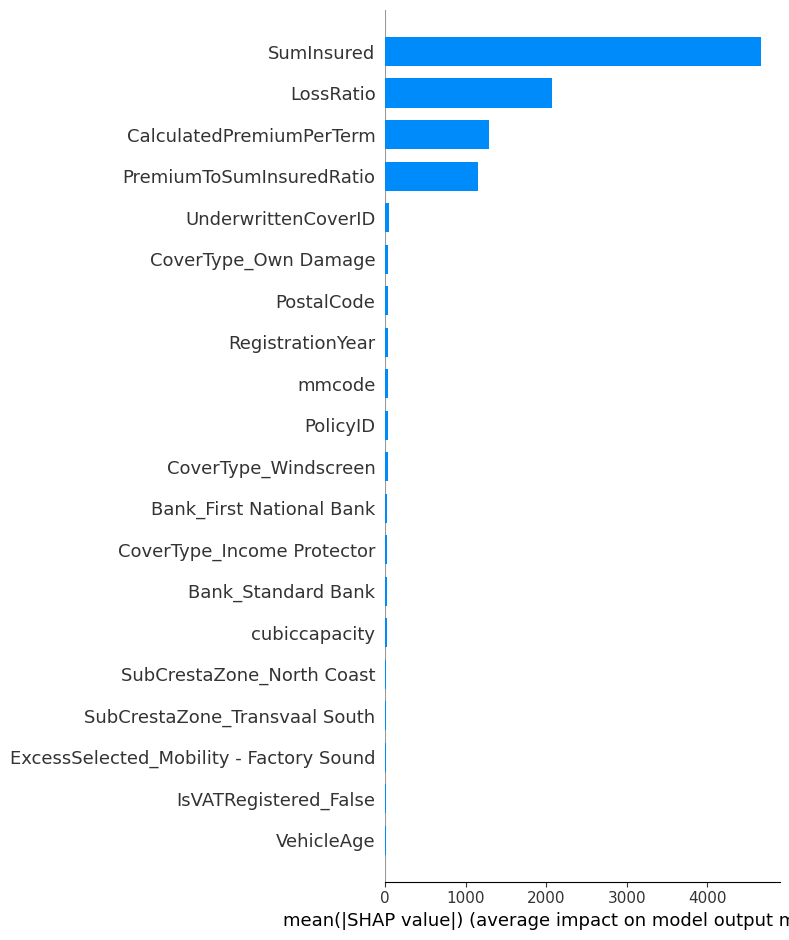

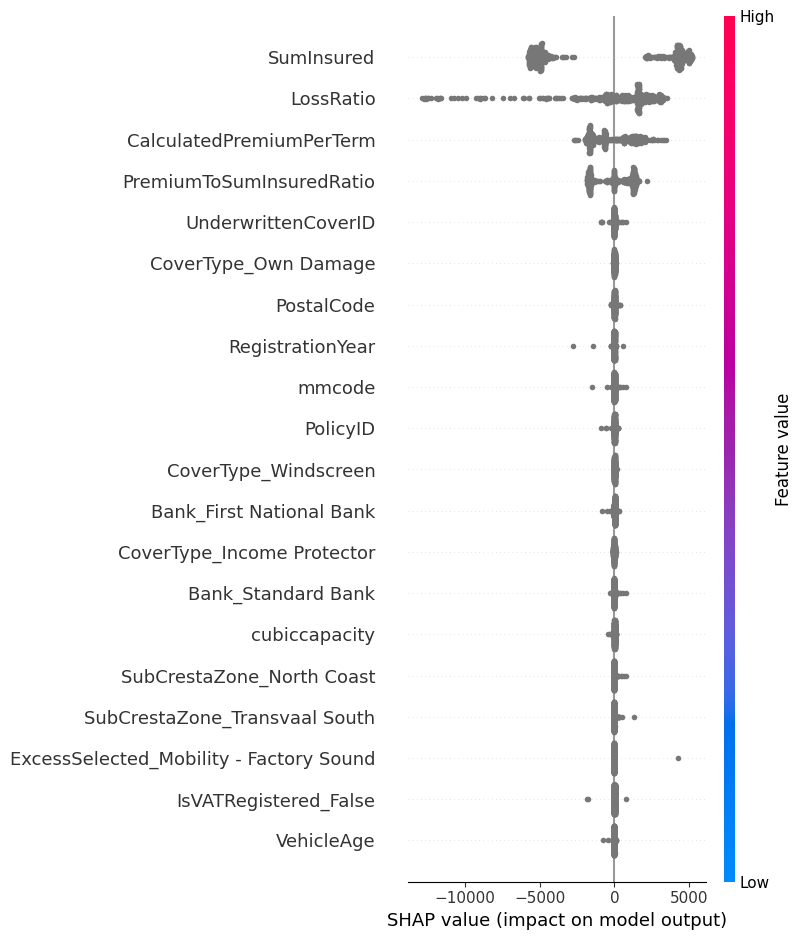

In [27]:
import shap

# 1. Preprocess the test data using the pipeline's preprocessor
X_sev_test_transformed = xgb_pipe.named_steps['preprocessor'].transform(X_sev_test)

# 2. Get feature names from the preprocessor
numeric_features = num_cols.tolist()
onehot_encoder = xgb_pipe.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
categorical_features = onehot_encoder.get_feature_names_out(cat_cols).tolist()
all_feature_names = numeric_features + categorical_features

# 3. Create SHAP explainer
explainer = shap.TreeExplainer(xgb_pipe.named_steps['estimator'])

# 4. Calculate SHAP values using the transformed test data
shap_values = explainer.shap_values(X_sev_test_transformed)

# 5. Create summary plot with proper feature names
shap.summary_plot(shap_values, X_sev_test_transformed, feature_names=all_feature_names, plot_type="bar")

# For more detailed analysis (beeswarm plot)
shap.summary_plot(shap_values, X_sev_test_transformed, feature_names=all_feature_names)

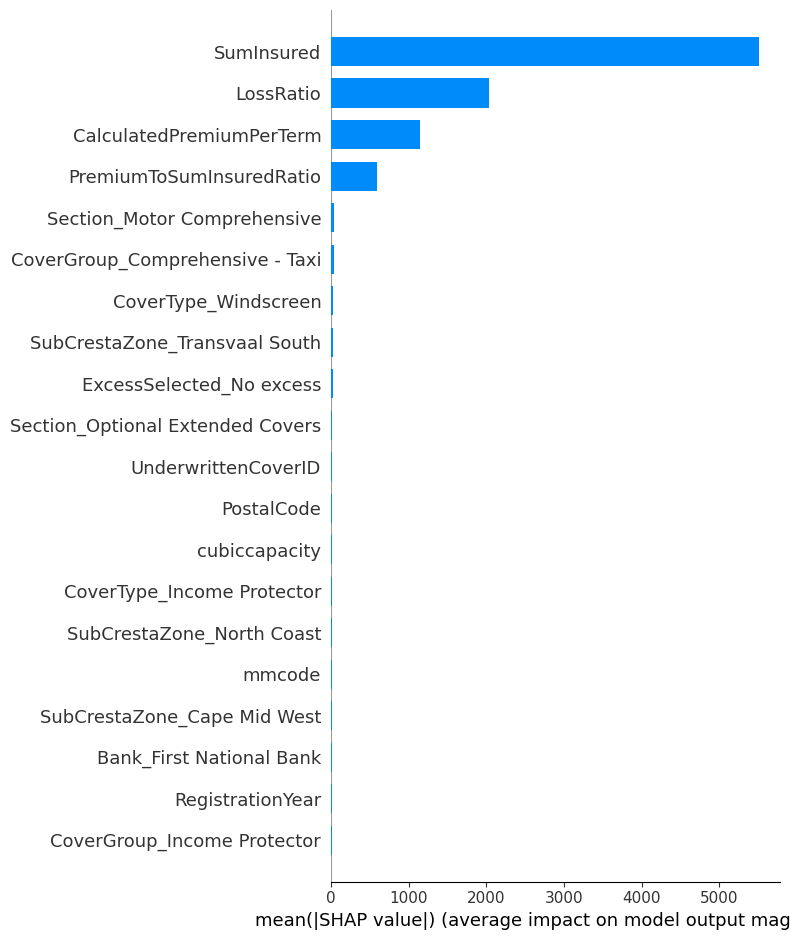

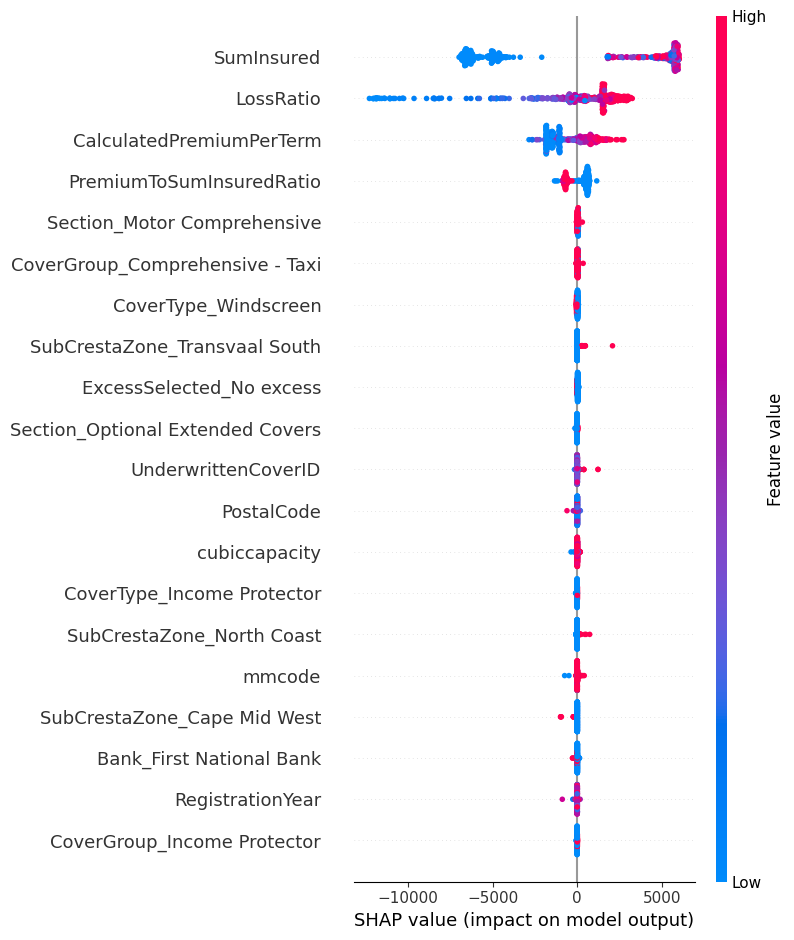

  0%|          | 0/555 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import shap
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Get the transformed test data from the pipeline
X_test_transformed = rf_pipe.named_steps['preprocessor'].transform(X_sev_test)

# If the output is sparse (from one-hot encoding), convert to dense
if hasattr(X_test_transformed, 'toarray'):
    X_test_transformed = X_test_transformed.toarray()

# Get feature names from the preprocessor
numeric_features = num_cols.tolist()  # Your numerical columns
categorical_features = rf_pipe.named_steps['preprocessor'].named_transformers_['cat']\
                      .named_steps['onehot'].get_feature_names_out(cat_cols).tolist()
all_feature_names = numeric_features + categorical_features

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_pipe.named_steps['estimator'])

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_transformed)

# Create summary plot
shap.summary_plot(shap_values, X_test_transformed, feature_names=all_feature_names, plot_type="bar")

# For detailed analysis (beeswarm plot)
shap.summary_plot(shap_values, X_test_transformed, feature_names=all_feature_names)


# Create a prediction function from your pipeline
def predict_fn(X):
    return rf_pipe.predict(pd.DataFrame(X, columns=X_sev_test.columns))

# Create explainer
explainer = shap.KernelExplainer(predict_fn, shap.sample(X_sev_test, 100))  # Use sample for reference

# Calculate SHAP values (this may take longer)
shap_values = explainer.shap_values(X_sev_test)

# Create plots
shap.summary_plot(shap_values, X_sev_test, feature_names=X_sev_test.columns.tolist(), plot_type="bar")

Claim Occurance | Claim Probability

In [31]:
# For claim probability model (all policies)
X_prob = df.drop(['TotalClaims', 'TotalPremium'], axis=1)
y_prob = (df['TotalClaims'] > 0).astype(int)  # Binary indicator
X_prob_train, X_prob_test, y_prob_train, y_prob_test = train_test_split(X_prob, y_prob, test_size=0.2, random_state=42)

In [ ]:


# Load your data (replace with your actual data loading)
# df = pd.read_csv('your_data.csv')

# Prepare features and target
X = df.drop(['TotalClaims', 'TotalPremium'], axis=1)
y = (df['TotalClaims'] > 0).astype(int)  # Binary indicator

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle infinite values
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Identify column types
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Model pipelines
models = {
    'Logistic Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'Random Forest': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    'XGBoost': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42))
    ])
}

# Train and evaluate models
results = {}
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # probabilities for AUC
    
    # Evaluate
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    }

# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results).T
print(results_df)

# Optional: Feature importance for tree-based models
if 'Random Forest' in models:
    rf_model = models['Random Forest'].named_steps['classifier']
    feature_names = (list(numeric_cols) + 
                    list(models['Random Forest'].named_steps['preprocessor']
                        .named_transformers_['cat']
                        .named_steps['onehot']
                        .get_feature_names_out(categorical_cols)))
    
    importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nRandom Forest Feature Importances:")
    print(importances.head(10))

if 'XGBoost' in models:
    xgb_model = models['XGBoost'].named_steps['classifier']
    feature_names = (list(numeric_cols) + 
                    list(models['XGBoost'].named_steps['preprocessor']
                        .named_transformers_['cat']
                        .named_steps['onehot']
                        .get_feature_names_out(categorical_cols)))
    
    importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': xgb_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nXGBoost Feature Importances:")
    print(importances.head(10))

                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.999715   1.000000  0.900870  0.947850  0.994603
Random Forest        0.999670   0.998043  0.886957  0.939227  0.979056
XGBoost              0.999855   1.000000  0.949565  0.974130  0.997098

Random Forest Feature Importances:
                     Feature  Importance
12                 LossRatio    0.899573
0        UnderwrittenCoverID    0.017617
1                   PolicyID    0.011915
11  CalculatedPremiumPerTerm    0.006283
14  PremiumToSumInsuredRatio    0.005545
2                 PostalCode    0.005494
4           RegistrationYear    0.004067
10                SumInsured    0.004008
13                VehicleAge    0.003971
9         CapitalOutstanding    0.002199

XGBoost Feature Importances:
                                            Feature  Importance
12                                        LossRatio    0.999810
610                        ExcessSelected_No excess    0.000015
650    

Risk Premium

In [ ]:
# Using the best performing models from above (assuming XGBoost for both)
def calculate_risk_premium(data, severity_model, probability_model, expense_loading=0.2, profit_margin=0.1):
    # Predict probability of claim
    prob_claim = probability_model.predict_proba(data)[:, 1]
    
    # Predict claim severity
    predicted_severity = severity_model.predict(data)
    
    # Calculate risk-based premium
    risk_premium = prob_claim * predicted_severity
    total_premium = risk_premium * (1 + expense_loading + profit_margin)
    
    return total_premium

# Example usage
# Clean X_prob_test to remove inf and very large values
X_prob_test_clean = X_prob_test.replace([np.inf, -np.inf], np.nan)

# Optionally, fill remaining NaNs with median for numeric columns only
for col in X_prob_test_clean.select_dtypes(include=[np.number]).columns:
    X_prob_test_clean[col] = X_prob_test_clean[col].fillna(X_prob_test_clean[col].median())

# Use models['XGBoost'] as the probability model pipeline
test_premiums = calculate_risk_premium(X_prob_test_clean, xgb_model, models['XGBoost'])

In [39]:
test_premiums 

array([0., 0., 0., ..., 0., 0., 0.], shape=(199895,))